<a href="https://www.kaggle.com/code/gerardomacias/alzheimer-project-tensorflow?scriptVersionId=209838459" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# importemos primero algunas bibliotecas que nos vayan a ser de utilididad.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import cv2
from PIL import Image
import io
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

print(tf.__version__)

2.16.1


# Problema y estructura del Dataset
## Detección de Alzheimer a través de Imágnes

La enfermedad del Alzheimer es la causa más frecuente de demencia, esta enfermedad es un proceso neurodegenrativo de causa incierta y patogenia parcialmente conocida que afecta preferentemente a sujetos mayores de 65 años de edad, ocasionando en la mayoria de los casos pérdida progresiva de un tipo muy selectivo de memeoria. Constituye la forma más frecuente de demencia. Un diagnostico temprano puede ser la clave para poder manejar los síntomas y planificar un tratamiento. Este proyecto busca clasificar imágenes de resonancia magnética cerebral (MRI) en 4 categorias, basadas en el grado de demencia:

1. **Mild Demented (0)**: Etapa leve de demencia.
2. **Moderate Demented(1)**: Etapa moderada de demencia.
3. **Non Demented (2)**: Sin indicios de demencia.
4. **Very Mild Demented (3)**: Etapa muy leve de demencia.

La meta es desarrollar un modelo de aprendizaje profundo capaz de distinguir estas clases.

## Estructura del Dataset

El dataset viene dividido en  dos partes:
1. **Train split**: para entrenar el modelo
2. **Test split**: para evaluar el modelo

Ambas particiones están almacenadas en **formato parquet**, que es un formato columnar optimizado para procesamiento de datos, pero no para imágenes. Por lo que, antes de entrenar el modelo necesitamos transformar el dataset para que podamos utilizarlo.

Cada archivo parquet contiene:
* **Imágenes** (en algún formato serializado)
* **Etiquetas**: indican a qué clase pertenece cada imágen (0, 1, 2 o 3)

El dataset consiste en imagenes MRI del cerebro etiquetadas en 4 categorias:

- '0': Mild_Demented
- '1': Moderate_Demented
- '2': Non_Demented
- '3': Very_Mild_Demented

### Información del dataset

- Train split:
  - Name: train
  - Number of bytes: 22,560,791.2
  - Number of examples: 5,120

- Test split:
  - Name: test
  - Number of bytes: 5,637,447.08
  - Number of examples: 1,280

- Download size: 28,289,848 bytes
- Dataset size: 28,198,238.28 bytes

### Cita

If you use this dataset in your research or health medicine applications, we kindly request that you cite the following publication:
```
@dataset{alzheimer_mri_dataset,
  author = {Falah.G.Salieh},
  title = {Alzheimer MRI Dataset},
  year = {2023},
  publisher = {Hugging Face},
  version = {1.0},
  url = {https://huggingface.co/datasets/Falah/Alzheimer_MRI}
}

# Lo siguiente es hacer un extraccion y transformacion de nuestros archivos parquet

tanto train como test vienen en archivos parquet, asi que usamos **pd.read_parquet** para extraer las imagenes

In [2]:
train = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'
test = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'
categorias = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}
data_train = pd.read_parquet(train)
data_test = pd.read_parquet(test)
data_train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


tenemos que hacer algunas transformaciones para poder trabajar con las imagenes en forma de matriz

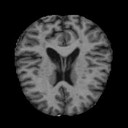

In [3]:
img_dict = data_train['image'][0]
byte_string = img_dict['bytes']
nparr = np.frombuffer(byte_string, np.uint8)
img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

image = Image.open(io.BytesIO(byte_string))
display(image)

In [4]:
def extraccion_y_transformacion(images_set):
    et_list_images = []
    images_bytes = images_set['image']
    for img_dict in images_bytes:
        byte_string = img_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        et_list_images.append(img)
    return et_list_images

def visualizar_imagenes(image_set, categorias, limit=5):
    fig, axes = plt.subplots(1, limit, figsize=(10, 5))
    image_bytes = image_set['image']

    for i, (ax, row) in enumerate(zip(axes, image_set.iterrows())):
        img_dict = row[1]['image']
        label = row[1]['label']
        name = categorias[label]
        
        byte_string = img_dict['bytes']
        image = Image.open(io.BytesIO(byte_string))
        
        ax.imshow(image, cmap='gray')
        ax.set_title(name) 
        ax.axis('off')
        
        if i + 1 == limit:
            break

    plt.tight_layout()
    plt.show()

In [5]:
train_transformado = extraccion_y_transformacion(data_train)
test_transformado = extraccion_y_transformacion(data_test)
print(train_transformado[:1])

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]


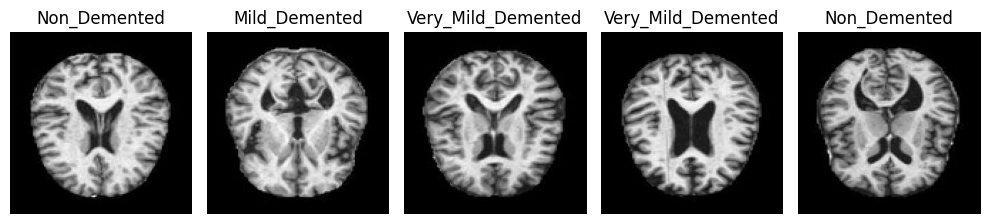

In [6]:
visualizar_imagenes(data_train, categorias, limit=5)

Hata aquí ya tenemos cargadas de forma correcta nuestras imagenes para poder pasarlas al modelo y entrenarlo con estas.

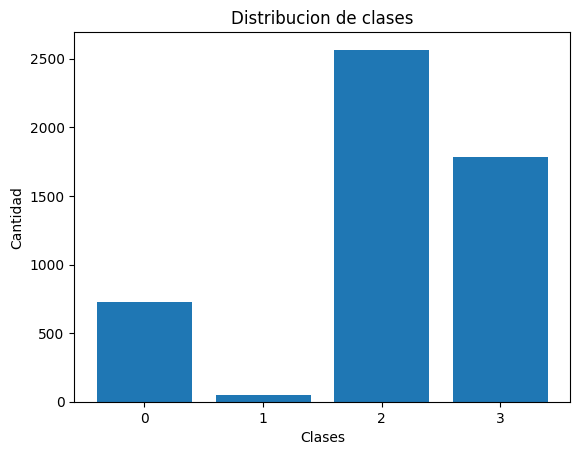

In [7]:
y_test = []
for label in data_test['label']:
    y_test.append(label)

y_train = []
for label in data_train['label']:
    y_train.append(label)
    
y_train = np.array(y_train)
y_test = np.array(y_test)

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Clases')
plt.ylabel('Cantidad')
plt.title('Distribucion de clases')
plt.xticks(unique) 
plt.show()

Podemos notar que  no tenemos clases balanceadas, así que podriamos optar por hace un aumneto de datos para intentar compensar eso. Pero de momento veamos cómo funciona el modelo si no hacemos nada respecto a la distribución de los datos.

## hacemos un one_hot encodign para la variable label
por ejemplo, si tenemos label = 2, se tendria que ver así [0,0,1,0]

In [8]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=4)
y_test = tf.one_hot(y_test.astype(np.int32), depth=4)
y_train

<tf.Tensor: shape=(5120, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

# vamos a estandarizar y normalizar nuestros datos

## normalizacion

In [9]:
train_transformado = np.array(train_transformado)/255
test_transformado = np.array(test_transformado)/255

## estandarizacion

In [10]:
train_transformado = [np.expand_dims(img, axis=-1) for img in train_transformado] # agregar el canal de escala de grises
test_transformado = [np.expand_dims(img, axis=-1) for img in test_transformado]
#test_transformado = [np.expand_dims(img, axis=-1) for img in test_transformado]
train_transformado = np.array(train_transformado)
test_transformado = np.array(test_transformado)
train_transformado[0].shape

(128, 128, 1)

In [11]:
train_transformado.shape

(5120, 128, 128, 1)

In [12]:
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

scaler = MinMaxScaler3D()
train_scaled = [scaler.fit_transform(X=img) for img in train_transformado]
train_scaled = np.array(train_scaled)
test_scaled = [scaler.fit_transform(X=img) for img in test_transformado]
test_scaled = np.array(test_scaled)

In [13]:
train_scaled.shape

(5120, 128, 128, 1)

# hagamos el modelo con keras

In [14]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential, initializers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

In [15]:
#optimizer = Adam()
optimizer = Adam(
    learning_rate=0.001,  # Tasa de aprendizaje
    beta_1=0.9,          # Decay rate del primer momento
    beta_2=0.999,        # Decay rate del segundo momento
    epsilon=1e-07        # Término de suavizado
)

model = Sequential([
    layers.Input(shape=(128,128,1)),
    
    layers.Conv2D(64, kernel_size=(2,2), activation='relu',kernel_initializer = initializers.HeNormal(seed=42), padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Dropout(0.25),
    
    layers.Conv2D(64,kernel_size=(2,2), activation='relu', kernel_initializer = initializers.HeNormal(seed=42), padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Dropout(0.25),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer = initializers.HeNormal(seed=42), padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(categorias), activation='softmax')
])

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# Arquitectura de la Red Neuronal

## Diseño de la Red

Lo que tenemos es una re convolucional (CNN) diseñada para clasificar imágenes (MRI) en 4 clases según el nivel de demencia. 

1. **Input**:\
   Una vez ya tranformadas los archivos parquet a imagenes con las que podemos trabajar tenemos lo siguiente. No redimensionamos las imagens, porque queremos capturar lo mejor posible cada detalle.
   * Tamaño de entrada: (128, 128, 1), tenemos imagenes en escala de grises.

2. **Capas Convolucionales**:\
   Sabemos que si vamos a trabajar con imagenes, es indispensable hacerlo usando capas convolucionales. \
   La capas convolucionales identifican caracteristicas especiales como bordes, texturas, etc. El número de filtros\
   permite capturar patrones más complejos en capas más profundas. En nuestra red contamos con 3 capas convolucionales:
   * **Primera y segunda capa**: 64 filtros, tamaños (2,2), activación ReLU, con inicialización HeNormal.
   * **Tercera capa**: 128 filtros, tamaño (3,3), activación ReLU, con inicialización HeNormal.

3. **Pooling**:\
   El MaxPooling lo que hace es reducir la resolución espacial  de las características minetras retiene información clave, diminuyendo el riesgo de sobreajuste.
   * **MaxPooling** (2,2) despues de cada convolución.

4. **Flat y Red Feedforward**:\
   Despues de las capas convolucionales, tenemos dos capas densas que usara la salida de las anteriores capas para realizar la clasificación
   * **Flatten**: convierte la salida 2D a un vector 1D
   * **Capa densa 1**: 
      * 256 unidades con activación ReLU
   * **Capa densa 2**: 
      * 4 unidades, del tamaño del número de clases, con activación softmax para predecir probabilidades de pertenecer a cada clase.

5. **Regularización**:
   * **Dropout(0.25)**: desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento, para mejorar la generalización.


## Funciones de Activación

* **ReLU**: la ocupamos en la mayoria de nuestras capas para manejar la no linealidad y evitar que el gradiente se vuelva muy pequeño.
* **Softmax**: solo lo usamos en la capa de salida para transformar los logits en probabilidades para clasificación multicategorica.

## Hiperparámetros

1. **Tasa de aprendizaje (learning_rate=0.001)**: este valor fue ideal al menos para nuestro modelo
2. **Optimizador Adam**: el que mejor funciona en la mayoria de casos\
    * **beta_1 = 0.9 y beta_2 = 0.999**, estos valores los usamos para una mejor estabilidad.
    * **epsilon = 1e-07**, este parametro lo usamos para evitar divisiones por cero.

3. **Inicialización de pesos HeNormal**: este inicializador de pesos se usa exclusivamente para la activación ReLU, con el proposito de evitar que nuestro gradiente explote o se desvanezca. 

## Motivación

1. **Capas convolucionales**: si vamos a trabajar con imagenes, usar capas convolucionales es el estandar.
2. **Profundidad de la red**: nuestra red no es muy prfunda, podriamos decir que son pocas capas, pero fueron las necesarias para alcanzar un buen nivel de clasificación, se probo con más y menos capas. Con menos capas el modelo no solia pasar de un 0.5 o 0.6 de accuracy, mientras que si aumentabamos el número de capas, al menos con las que intentamos, ya no obteniamos mejores resultados, terminaban siendo muy similares, así que nos quedamos con la estructura actual.
3. **Regularización**: solo utilizamos un **dropout** y con este nos fue suficiente para obtener buenos resultados.
4. **Optimizador**: utilizamos Adam como optimizador por su alta eficiencia y capacidad de adaptarse a distintos problemas.

## Toca entrenar el modelo

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.995):
            print("\nReached 99.5% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()
history = model.fit(
    train_scaled, 
    y_train,
    batch_size=10,
    epochs=20,
    validation_split=0.1,
    callbacks=[callbacks]
)

Epoch 1/20


I0000 00:00:1732675127.274902      81 service.cc:145] XLA service 0x7e2094009150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732675127.274953      81 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732675127.274957      81 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 21/461 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4410 - loss: 8.4791

I0000 00:00:1732675132.071473      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


461/461 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4960 - loss: 1.8987 - val_accuracy: 0.5859 - val_loss: 0.9287
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5872 - loss: 0.8970 - val_accuracy: 0.6289 - val_loss: 0.8332
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6237 - loss: 0.8204 - val_accuracy: 0.6465 - val_loss: 0.7838
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6766 - loss: 0.7026 - val_accuracy: 0.7500 - val_loss: 0.6016
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7468 - loss: 0.5808 - val_accuracy: 0.8047 - val_loss: 0.4528
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8291 - loss: 0.4170 - val_accuracy: 0.8477 - val_loss: 0.3964
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8757 - loss: 0.3090 - val_accuracy: 0.8691 - val_loss: 0.3402
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9187 - loss: 0.2044 - val_accuracy: 0.9023 - va

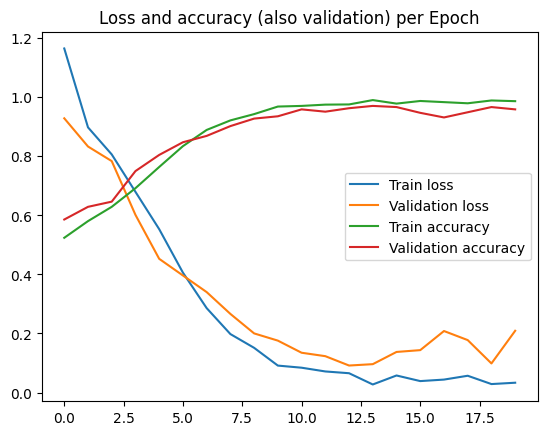

In [17]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Loss and accuracy (also validation) per Epoch')
plt.show()

In [18]:
history.model.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [19]:
w, b = history.model.layers[0].get_weights()

In [20]:
b.shape

(64,)

# evaluemos la exactitud del modelo

In [21]:
test_loss, test_acc = model.evaluate(test_scaled, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

40/40 - 1s - 25ms/step - accuracy: 0.9594 - loss: 0.2118
Test accuracy: 0.9593750238418579


In [22]:
predictions = model.predict(test_scaled)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [23]:
predictions[0]

array([3.7919035e-06, 1.0107176e-12, 1.3728665e-02, 9.8626757e-01],
      dtype=float32)

tenemos que la prediccion es un arreglo de 4 números. Estos números representan el nivel de confianza del modelo sobre cada una de las imagenes de las 4 clases que hay. Ahora veamos como se obtiene el nivel de confianza más alto

In [24]:
np.argmax(predictions[0])

3

el modelo tiene más confinza en que la primera imagen pertenece a la clase 3, o bien que la radiografia pertenece a **Very_Mild_Demented**

In [25]:
data_test['label'][0]

3

y vemos que en efecto ha acertado.\

Aunque puede llegar a variar si volvemos a correr el modelo sin guardar los pesos xd.

In [26]:
from sklearn.metrics import classification_report
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
report = classification_report(true_classes, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.87      0.92       172
           1       1.00      0.93      0.97        15
           2       0.97      0.98      0.97       634
           3       0.94      0.97      0.95       459

    accuracy                           0.96      1280
   macro avg       0.97      0.94      0.95      1280
weighted avg       0.96      0.96      0.96      1280



# graficos

In [27]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(categorias[predicted_label],
                                100*np.max(predictions_array),
                                categorias[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

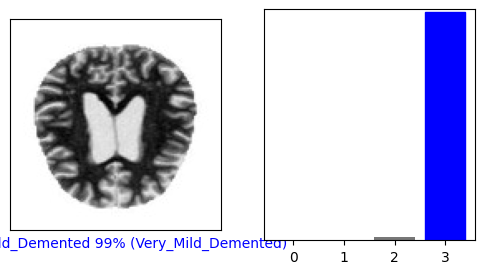

In [28]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], np.argmax(y_test, axis=1), test_scaled)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], np.argmax(y_test, axis=1))
plt.show()

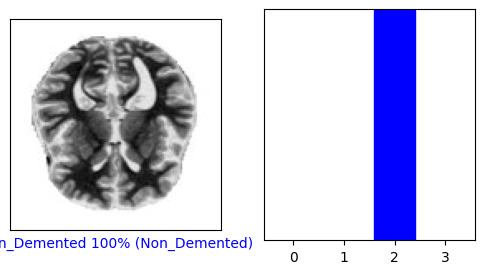

In [29]:
i = 8
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], np.argmax(y_test, axis=1), test_scaled)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], np.argmax(y_test, axis=1))
plt.show()

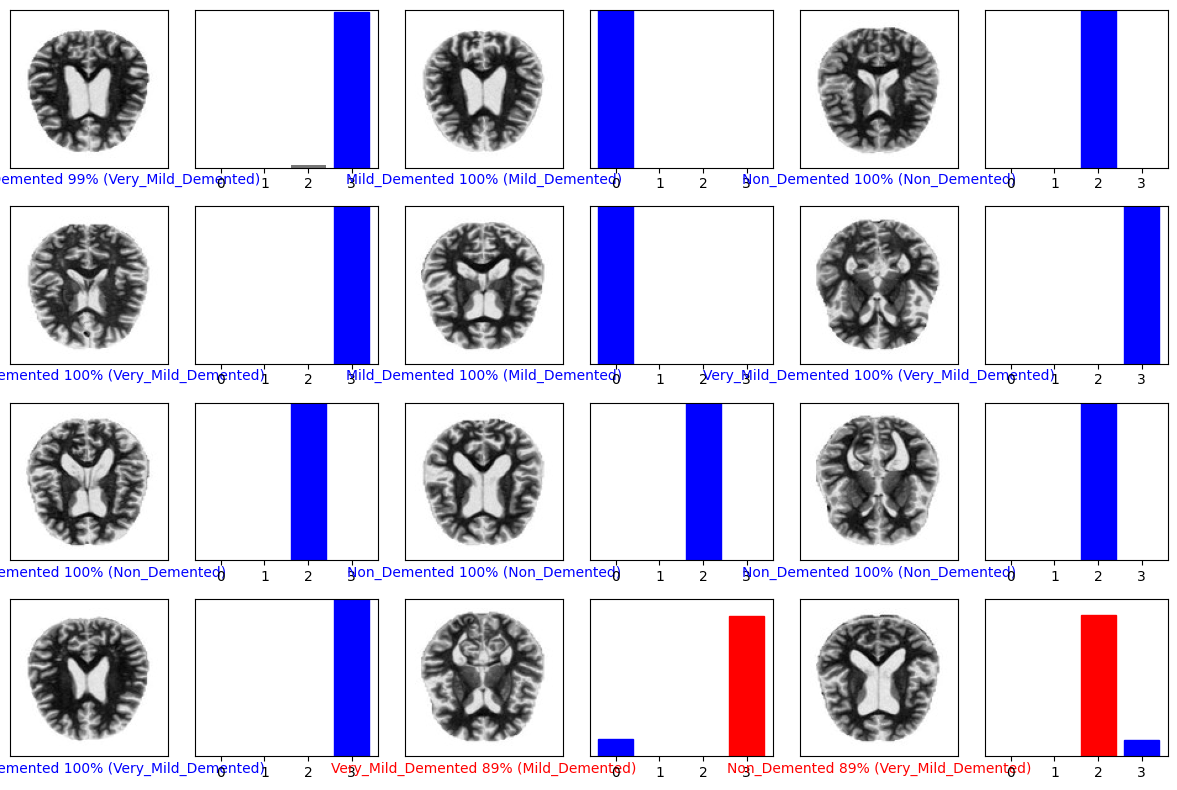

In [30]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], np.argmax(y_test, axis=1), test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], np.argmax(y_test, axis=1))
plt.tight_layout()
plt.show()

# Fuente del Dataset

@dataset{alzheimer_mri_dataset,\
  author = {Falah.G.Salieh},\
  title = {Alzheimer MRI Dataset},\
  year = {2023},\
  publisher = {Hugging Face},\
  version = {1.0},\
  url = {https://huggingface.co/datasets/Falah/Alzheimer_MRI}\
}